In [5]:
%matplotlib inline
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


In [6]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [7]:
Transition = namedtuple('Transition',
                        ('state_before', 'state_after', 'screen_before', 'screen_after', 'action', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [8]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [s for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold for a in actions_batch[i]]
    
    return elite_states, elite_actions

from IPython.display import clear_output


def show_progress(rewards_batch, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    #plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [9]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((int(400/15),int(600/15)), interpolation=Image.BICUBIC),
                    T.ToTensor()])
def get_screen():
    screen = env.render(mode='rgb_array')
    screen = resize(screen)
    return screen

In [10]:
env = gym.make("LunarLander-v2").env
env.reset()
n_actions = env.action_space.n

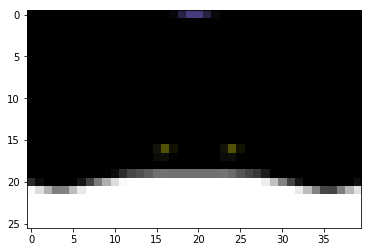

In [11]:
plt.imshow(get_screen().permute(1,2,0))

In [12]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1  # make only 1 iteration on each .fit(...)
                     )
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [24]:
memory = ReplayMemory(10000)

In [296]:
# def generate_session(t_max=1000):

#     states, actions = [], []
#     total_reward = 0

#     s = env.reset()

#     for t in tqdm_notebook(range(t_max)):
        
#         s_before = get_screen()
#         probs = agent.predict_proba([s])[0]
#         a = np.random.choice(n_actions,p=probs)
#         new_s, r, done, info = env.step(a)
#         s_after = get_screen()
        
#         states.append(s)
#         actions.append(a)
#         total_reward += r
#         #'state_before', 'state_after', 'screen_before', 'screen_after', 'action', 'reward'
#         memory.push(s, new_s, s_before, s_after, a, r)

#         s = new_s
#         if done:
#             break
#     return states, actions, total_reward

def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()
    screen = get_screen()
    
    for t in tqdm_notebook(range(t_max)):

        # predict array of action probabilities
        s = nn_1(screen.reshape(1,3,26,40))
        
        probs = agent.predict_proba([s[0].detach().numpy()])[0]

        a = np.random.choice(n_actions,p=probs)

        _ , r, done, info = env.step(a)
        
        s_2 = nn_1(get_screen().reshape(1,3,26,40))[0].detach().numpy()

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = s_2
        if done:
            break
    return states, actions, total_reward

In [297]:
from tqdm import tqdm_notebook

In [298]:
n_sessions = 100
percentile = 70
log = []

for i in tqdm_notebook(range(100)):
    # generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print('epoch', i)
        print("You Win! You may stop training now via KeyboardInterrupt.")

ValueError: Expected 2D array, got 1D array instead:
array=[tensor([[ 0.0256,  1.5176, -0.0841, -0.1320, -0.0237,  0.0154,  0.6519,  0.6535]],
       grad_fn=<ThAddmmBackward>)
 tensor([[ 0.0256,  1.5176, -0.0841, -0.1320, -0.0237,  0.0154,  0.6519,  0.6535]],
       grad_fn=<ThAddmmBackward>)
 tensor([[ 0.0256,  1.5176, -0.0841, -0.1320, -0.0237,  0.0154,  0.6519,  0.6535]],
       grad_fn=<ThAddmmBackward>)
 ...
 tensor([[ 0.0075,  1.2985,  0.0602, -0.2600,  0.0226, -0.0159,  0.1791,  0.1643]],
       grad_fn=<ThAddmmBackward>)
 tensor([[ 0.0075,  1.2985,  0.0602, -0.2600,  0.0226, -0.0159,  0.1791,  0.1643]],
       grad_fn=<ThAddmmBackward>)
 tensor([[ 0.0075,  1.2985,  0.0602, -0.2600,  0.0226, -0.0159,  0.1791,  0.1643]],
       grad_fn=<ThAddmmBackward>)].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
#'state_before', 'state_after', 'screen_before', 'screen_after', 'action', 'reward'

In [239]:
data = memory.sample(10000)

In [240]:
data = Transition(*zip(*data))

In [232]:
state_before = data.state_before
state_after = data.state_after
screen_before = data.screen_before
screen_after  = data.screen_after 
action = data.action
reward = data.reward

In [225]:
states = torch.Tensor([i for i in states])

state_before = torch.Tensor([i for i ])
state_after = torch.Tensor([i for i ])
screen_before = torch.Tensor([i for i ])
screen_after = torch.Tensor([i for i ])
action = torch.Tensor([i for i ])
reward = torch.Tensor([i for i ])

In [230]:
torch.save(states, 'states.pt')

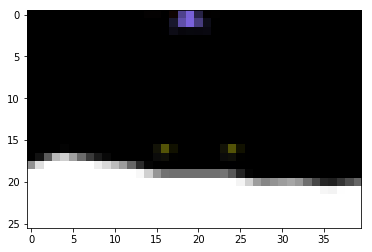

In [244]:
plt.imshow(screen_before[0].permute(1,2,0))

# nn_1(image) - > state

In [317]:
#Define a Convolution Neural Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        self.fc1 = nn.Linear(16 * 7 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.fc1(x)
        #x = self.fc2(x)
        x = self.fc3(x)
        return x
    
nn_1 = Net()

In [319]:
nn_1(get_screen().reshape(1,3,26,40))

tensor([[ 0.0113,  0.0040, -0.0714, -0.0456,  0.0315,  0.0535, -0.0887,  0.0074],
        [ 0.0023,  0.0048, -0.0855, -0.0447,  0.0334,  0.0570, -0.0923,  0.0128],
        [-0.0066,  0.0163, -0.0740, -0.0394,  0.0385,  0.0594, -0.0936,  0.0112],
        [ 0.0104,  0.0033, -0.0785, -0.0372,  0.0303,  0.0687, -0.0816,  0.0241]],
       grad_fn=<ThAddmmBackward>)

In [245]:
import torch.optim as optim

criterion = nn.L1Loss()
optimizer = optim.SGD(nn_1.parameters(), lr=0.001, momentum=0.9)

In [246]:
from tqdm import tqdm_notebook

In [249]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for state, screen in tqdm_notebook(zip(state_before, screen_before)):
        
        # get the inputs
        inputs, labels = screen.reshape(1, 3, 26 , 40), torch.FloatTensor(state).reshape([1,8])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nn_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        i+=1
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.174
[1,  4000] loss: 0.167
[1,  6000] loss: 0.164
[1,  8000] loss: 0.160
[1, 10000] loss: 0.143


[2,  2000] loss: 0.142
[2,  4000] loss: 0.138
[2,  6000] loss: 0.135
[2,  8000] loss: 0.132
[2, 10000] loss: 0.126


[3,  2000] loss: 0.128
[3,  4000] loss: 0.128
[3,  6000] loss: 0.127
[3,  8000] loss: 0.124
[3, 10000] loss: 0.120


[4,  2000] loss: 0.122
[4,  4000] loss: 0.123
[4,  6000] loss: 0.123
[4,  8000] loss: 0.121
[4, 10000] loss: 0.117


[5,  2000] loss: 0.119
[5,  4000] loss: 0.121
[5,  6000] loss: 0.121
[5,  8000] loss: 0.119
[5, 10000] loss: 0.115


[6,  2000] loss: 0.117
[6,  4000] loss: 0.119
[6,  6000] loss: 0.119
[6,  8000] loss: 0.117
[6, 10000] loss: 0.114


[7,  2000] loss: 0.116
[7,  4000] loss: 0.117
[7,  6000] loss: 0.118
[7,  8000] loss: 0.116
[7, 10000] loss: 0.113


[8,  2000] loss: 0.114
[8,  4000] loss: 0.116
[8,  6000] loss: 0.117
[8,  8000] loss: 0.115
[8, 10000] loss: 0.112


[9,  2000] loss: 0.114
[9,  4000] loss: 0.115
[9,  6000] loss: 0.116
[9,  8000] loss: 0.115
[9, 10000] loss: 0.111


[10,  2000] loss: 0.113
[10,  4000] loss: 0.114
[10,  6000] loss: 0.116
[10,  8000] loss: 0.114
[10, 10000] loss: 0.110


[11,  2000] loss: 0.112
[11,  4000] loss: 0.113
[11,  6000] loss: 0.115
[11,  8000] loss: 0.113
[11, 10000] loss: 0.110


[12,  2000] loss: 0.111
[12,  4000] loss: 0.113
[12,  6000] loss: 0.114
[12,  8000] loss: 0.113
[12, 10000] loss: 0.109


[13,  2000] loss: 0.111
[13,  4000] loss: 0.112
[13,  6000] loss: 0.114
[13,  8000] loss: 0.112
[13, 10000] loss: 0.109


[14,  2000] loss: 0.110
[14,  4000] loss: 0.112
[14,  6000] loss: 0.113
[14,  8000] loss: 0.112
[14, 10000] loss: 0.108


[15,  2000] loss: 0.110
[15,  4000] loss: 0.111
[15,  6000] loss: 0.113
[15,  8000] loss: 0.111
[15, 10000] loss: 0.108


[16,  2000] loss: 0.109
[16,  4000] loss: 0.111
[16,  6000] loss: 0.113
[16,  8000] loss: 0.111
[16, 10000] loss: 0.107


[17,  2000] loss: 0.109
[17,  4000] loss: 0.110
[17,  6000] loss: 0.112
[17,  8000] loss: 0.110
[17, 10000] loss: 0.107


[18,  2000] loss: 0.108
[18,  4000] loss: 0.110
[18,  6000] loss: 0.112
[18,  8000] loss: 0.110
[18, 10000] loss: 0.107


[19,  2000] loss: 0.108
[19,  4000] loss: 0.109
[19,  6000] loss: 0.111
[19,  8000] loss: 0.109
[19, 10000] loss: 0.107


[20,  2000] loss: 0.107
[20,  4000] loss: 0.109
[20,  6000] loss: 0.110
[20,  8000] loss: 0.108
[20, 10000] loss: 0.106


[21,  2000] loss: 0.105
[21,  4000] loss: 0.106
[21,  6000] loss: 0.105
[21,  8000] loss: 0.102
[21, 10000] loss: 0.100


[22,  2000] loss: 0.099
[22,  4000] loss: 0.100
[22,  6000] loss: 0.099
[22,  8000] loss: 0.095
[22, 10000] loss: 0.096


[23,  2000] loss: 0.095
[23,  4000] loss: 0.095
[23,  6000] loss: 0.096
[23,  8000] loss: 0.092
[23, 10000] loss: 0.093


[24,  2000] loss: 0.091
[24,  4000] loss: 0.092
[24,  6000] loss: 0.093
[24,  8000] loss: 0.089
[24, 10000] loss: 0.091


[25,  2000] loss: 0.089
[25,  4000] loss: 0.090
[25,  6000] loss: 0.090
[25,  8000] loss: 0.087
[25, 10000] loss: 0.089


[26,  2000] loss: 0.087
[26,  4000] loss: 0.088
[26,  6000] loss: 0.088
[26,  8000] loss: 0.084
[26, 10000] loss: 0.088


[27,  2000] loss: 0.084
[27,  4000] loss: 0.086
[27,  6000] loss: 0.086
[27,  8000] loss: 0.083
[27, 10000] loss: 0.086


[28,  2000] loss: 0.085
[28,  4000] loss: 0.084
[28,  6000] loss: 0.086
[28,  8000] loss: 0.082
[28, 10000] loss: 0.084


[29,  2000] loss: 0.082
[29,  4000] loss: 0.084
[29,  6000] loss: 0.083
[29,  8000] loss: 0.080
[29, 10000] loss: 0.083


[30,  2000] loss: 0.082
[30,  4000] loss: 0.084
[30,  6000] loss: 0.082
[30,  8000] loss: 0.080
[30, 10000] loss: 0.082


[31,  2000] loss: 0.081
[31,  4000] loss: 0.080
[31,  6000] loss: 0.081
[31,  8000] loss: 0.082
[31, 10000] loss: 0.082


[32,  2000] loss: 0.081
[32,  4000] loss: 0.080
[32,  6000] loss: 0.080
[32,  8000] loss: 0.079
[32, 10000] loss: 0.081


[33,  2000] loss: 0.080
[33,  4000] loss: 0.081
[33,  6000] loss: 0.079
[33,  8000] loss: 0.079
[33, 10000] loss: 0.083


[34,  2000] loss: 0.080
[34,  4000] loss: 0.081
[34,  6000] loss: 0.082
[34,  8000] loss: 0.080
[34, 10000] loss: 0.080


[35,  2000] loss: 0.080
[35,  4000] loss: 0.080
[35,  6000] loss: 0.081
[35,  8000] loss: 0.079
[35, 10000] loss: 0.083


[36,  2000] loss: 0.082
[36,  4000] loss: 0.079
[36,  6000] loss: 0.079
[36,  8000] loss: 0.077
[36, 10000] loss: 0.081


[37,  2000] loss: 0.081
[37,  4000] loss: 0.078
[37,  6000] loss: 0.077
[37,  8000] loss: 0.077
[37, 10000] loss: 0.078


[38,  2000] loss: 0.078
[38,  4000] loss: 0.077
[38,  6000] loss: 0.077
[38,  8000] loss: 0.079
[38, 10000] loss: 0.077


[39,  2000] loss: 0.077
[39,  4000] loss: 0.077
[39,  6000] loss: 0.076
[39,  8000] loss: 0.076
[39, 10000] loss: 0.077


[40,  2000] loss: 0.077
[40,  4000] loss: 0.078
[40,  6000] loss: 0.077
[40,  8000] loss: 0.078
[40, 10000] loss: 0.078


[41,  2000] loss: 0.077
[41,  4000] loss: 0.077
[41,  6000] loss: 0.077
[41,  8000] loss: 0.078
[41, 10000] loss: 0.078


[42,  2000] loss: 0.077
[42,  4000] loss: 0.077
[42,  6000] loss: 0.076
[42,  8000] loss: 0.079
[42, 10000] loss: 0.077


[43,  2000] loss: 0.080
[43,  4000] loss: 0.076
[43,  6000] loss: 0.077
[43,  8000] loss: 0.075
[43, 10000] loss: 0.078


[44,  2000] loss: 0.076
[44,  4000] loss: 0.075
[44,  6000] loss: 0.075
[44,  8000] loss: 0.076
[44, 10000] loss: 0.077


[45,  2000] loss: 0.076
[45,  4000] loss: 0.075
[45,  6000] loss: 0.075
[45,  8000] loss: 0.076
[45, 10000] loss: 0.077


[46,  2000] loss: 0.078
[46,  4000] loss: 0.076
[46,  6000] loss: 0.074
[46,  8000] loss: 0.075
[46, 10000] loss: 0.077


[47,  2000] loss: 0.075
[47,  4000] loss: 0.075
[47,  6000] loss: 0.075
[47,  8000] loss: 0.077
[47, 10000] loss: 0.077


[48,  2000] loss: 0.076
[48,  4000] loss: 0.074
[48,  6000] loss: 0.074
[48,  8000] loss: 0.075
[48, 10000] loss: 0.076


[49,  2000] loss: 0.076
[49,  4000] loss: 0.075
[49,  6000] loss: 0.076
[49,  8000] loss: 0.075
[49, 10000] loss: 0.076


[50,  2000] loss: 0.075
[50,  4000] loss: 0.074
[50,  6000] loss: 0.075
[50,  8000] loss: 0.075
[50, 10000] loss: 0.076


[51,  2000] loss: 0.074
[51,  4000] loss: 0.072
[51,  6000] loss: 0.074
[51,  8000] loss: 0.074
[51, 10000] loss: 0.075


[52,  2000] loss: 0.074
[52,  4000] loss: 0.074
[52,  6000] loss: 0.075
[52,  8000] loss: 0.073
[52, 10000] loss: 0.076


[53,  2000] loss: 0.075
[53,  4000] loss: 0.073
[53,  6000] loss: 0.073
[53,  8000] loss: 0.073
[53, 10000] loss: 0.074


[54,  2000] loss: 0.074
[54,  4000] loss: 0.073
[54,  6000] loss: 0.076
[54,  8000] loss: 0.075
[54, 10000] loss: 0.074


[55,  2000] loss: 0.074
[55,  4000] loss: 0.074
[55,  6000] loss: 0.074
[55,  8000] loss: 0.073
[55, 10000] loss: 0.075


[56,  2000] loss: 0.074
[56,  4000] loss: 0.073
[56,  6000] loss: 0.073
[56,  8000] loss: 0.072
[56, 10000] loss: 0.073


[57,  2000] loss: 0.074
[57,  4000] loss: 0.071
[57,  6000] loss: 0.073
[57,  8000] loss: 0.074
[57, 10000] loss: 0.074


[58,  2000] loss: 0.074
[58,  4000] loss: 0.072
[58,  6000] loss: 0.074
[58,  8000] loss: 0.073
[58, 10000] loss: 0.074


[59,  2000] loss: 0.072
[59,  4000] loss: 0.075
[59,  6000] loss: 0.073
[59,  8000] loss: 0.072
[59, 10000] loss: 0.076


[60,  2000] loss: 0.072
[60,  4000] loss: 0.073
[60,  6000] loss: 0.074
[60,  8000] loss: 0.073
[60, 10000] loss: 0.074


[61,  2000] loss: 0.073
[61,  4000] loss: 0.073
[61,  6000] loss: 0.072
[61,  8000] loss: 0.073
[61, 10000] loss: 0.074


[62,  2000] loss: 0.071
[62,  4000] loss: 0.072
[62,  6000] loss: 0.074
[62,  8000] loss: 0.072
[62, 10000] loss: 0.074


[63,  2000] loss: 0.072
[63,  4000] loss: 0.073
[63,  6000] loss: 0.077


KeyboardInterrupt: 

Check 
--------

In [327]:
nn_1(screens[4030].reshape(1,3,26,40))

tensor([[ 0.0087,  0.0064, -0.0710, -0.0445,  0.0339,  0.0560, -0.0901,  0.0081],
        [ 0.0032,  0.0086, -0.0845, -0.0440,  0.0336,  0.0587, -0.0939,  0.0128],
        [-0.0062,  0.0190, -0.0778, -0.0438,  0.0388,  0.0583, -0.0902,  0.0118],
        [ 0.0070,  0.0008, -0.0794, -0.0375,  0.0336,  0.0678, -0.0851,  0.0233]],
       grad_fn=<ThAddmmBackward>)

In [326]:
states[4030]

tensor([ 0.1300,  0.0026, -0.0066, -0.0263,  0.0241,  0.0616,  0.0000,  0.0000])

In [301]:
s = env.reset()

In [282]:
s

array([-0.00610332,  1.4218495 , -0.6182208 ,  0.48573384,  0.00707906,
        0.14003623,  0.        ,  0.        ], dtype=float32)

In [321]:
get_screen().shape

torch.Size([3, 26, 40])

In [323]:
screens[4030].shape

torch.Size([3, 26, 40])